In [88]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import time
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
import matplotlib.pyplot as plt

# Web Scrapping 

Getting news from "El País" in the English version

In [108]:
url = "https://elpais.com/elpais/inenglish.html"

# Request url
r1 = requests.get(url)
r1.status_code

# We'll save in coverpage the cover page content
coverpage = r1.content
soup1 = BeautifulSoup(coverpage, 'html5lib')

# Find news headers in main page
coverpage_news = soup1.find_all('h2')
len(coverpage_news)

72

Now, let's get news content

In [109]:
number_of_articles = 72
news_contents = []
list_links = []
list_titles = []

for n in np.arange(0, number_of_articles):
        
    # We need to ignore "live" pages since they are not articles
    if "live" in coverpage_news[n].find('a')['href']:  
        continue
    
    # Getting the link of the article
    link = 'https://english.elpais.com' + coverpage_news[n].find('a')['href']
    list_links.append(link)
    
    # Getting the title
    title = coverpage_news[n].find('a').get_text()
    list_titles.append(title)
    
    # Reading the content 
    article = requests.get(link)
    article_content = article.content
    soup_article = BeautifulSoup(article_content, 'html5lib')
    body = soup_article.find_all(id = 'ctn_article_body')
    if len(body) != 0:
        x = body[0].find_all('p')
    
    # Unifying the paragraphs
    list_paragraphs = []
    for p in np.arange(0, len(x)):
        paragraph = x[p].get_text()
        list_paragraphs.append(paragraph)
        final_article = " ".join(list_paragraphs)
        
    news_contents.append(final_article)

Finally we create news dataframe using pandas:

In [110]:
# df_show_info
df_show_info = pd.DataFrame(
    {'Article Title': list_titles,
     'Article Link': list_links,
     'Article Content': news_contents })



,Article Title,Article Link,Article Content
0,Spain sees record fall in unemployment in June...,https://english.elpais.com/economy-and-busines...,The reactivation of the Spanish economy is pro...
1,Spain reports new rise in coronavirus infectio...,https://english.elpais.com/society/2021-07-02/...,"From April 26 onward, the cumulative incidence..."
2,Abandoned Dutch bikes get a second shot at lif...,https://english.elpais.com/society/2021-07-02/...,Cities in the Netherlands are crowded with bik...
3,Students confined in Mallorca after mass coron...,https://english.elpais.com/society/2021-07-02/...,A total of 118 of the students who were confin...
4,Doubts on day one of the EU’s Digital Covid Ce...,https://english.elpais.com/society/2021-07-02/...,The Adolfo Suárez-Madrid Barajas Airport was s...
...,...,...,...
66,Sign up to the EL PAÍS English Edition newsletter,https://english.elpais.com/spain/2021-06-09/si...,Puzzled by Podemos? Stumped by the Socialists?...
67,EL PAÍS teams up with Gymglish to offer person...,https://english.elpais.com/media/2020-10-22/el...,EL PAÍS has teamed up with the language-learni...
68,Basque ‘genetic singularity’ confirmed in larg...,https://english.elpais.com/usa/2021-04-01/basq...,"The largest-ever study of almost 2,000 DNA sam..."
69,Covid-19 takes the life of the last male from ...,https://english.elpais.com/usa/2021-02-22/covi...,"Aruká Juma, a native Brazilian, was aged betwe..."


# LDA - Topic Modeling 

First, we create the vocabulary for the model removing stop words.

In [114]:
count_vect = CountVectorizer(max_df=0.8, min_df=2, stop_words='english')
vocabulary = count_vect.fit_transform(df_show_info['Article Content'].values.astype('U'))

In [115]:
vocabulary

<71x3712 sparse matrix of type '<class 'numpy.int64'>'
	with 18459 stored elements in Compressed Sparse Row format>

Then, let's define the model Building the model: 

In [117]:
lda_model = LatentDirichletAllocation(n_components=5,              
                                      max_iter=10, learning_method='online', random_state=100, batch_size=128,            
                                      evaluate_every = -1,       
                                      n_jobs = -1)
lda_output = lda_model.fit_transform(vocabulary)
# Print model attributes
print(lda_model)  


LatentDirichletAllocation(learning_method='online', n_components=5, n_jobs=-1,
                          random_state=100)


In [123]:
first_topic = lda_model.components_[0]

In [124]:
top_topic_words = first_topic.argsort()[-10:]

We can take a look on the clustered words by topic: 

In [125]:
for i,topic in enumerate(LDA.components_):
    print(f'Top 10 words for topic #{i}:')
    print([count_vect.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #0:
['covid', '19', 'infected', 'vaccinated', 'ventilation', 'risk', '100', 'air', 'people', '000']


Top 10 words for topic #1:
['says', 'european', 'country', '000', 'young', 'years', 'cases', 'new', 'spain', 'people']


Top 10 words for topic #2:
['test', 'people', 'british', 'coronavirus', 'said', 'travel', 'spanish', 'government', 'uk', 'spain']


Top 10 words for topic #3:
['national', 'year', 'want', 'says', 'new', 'spain', 'women', 'like', 'people', 'spanish']


Top 10 words for topic #4:
['households', 'nacional', 'genetic', '30', 'spain', 'vaccines', 'people', 'cuban', 'basque', 'cuba']




In [126]:
topic_values = LDA.transform(vocabulary)
topic_values.shape

(71, 5)

In [128]:
df_show_info['Topic'] = topic_values.argmax(axis=1)
df_show_info

,Article Title,Article Link,Article Content,Topic
0,Spain sees record fall in unemployment in June...,https://english.elpais.com/economy-and-busines...,The reactivation of the Spanish economy is pro...,0
1,Spain reports new rise in coronavirus infectio...,https://english.elpais.com/society/2021-07-02/...,"From April 26 onward, the cumulative incidence...",1
2,Abandoned Dutch bikes get a second shot at lif...,https://english.elpais.com/society/2021-07-02/...,Cities in the Netherlands are crowded with bik...,0
3,Students confined in Mallorca after mass coron...,https://english.elpais.com/society/2021-07-02/...,A total of 118 of the students who were confin...,2
4,Doubts on day one of the EU’s Digital Covid Ce...,https://english.elpais.com/society/2021-07-02/...,The Adolfo Suárez-Madrid Barajas Airport was s...,2
...,...,...,...,...
66,Sign up to the EL PAÍS English Edition newsletter,https://english.elpais.com/spain/2021-06-09/si...,Puzzled by Podemos? Stumped by the Socialists?...,1
67,EL PAÍS teams up with Gymglish to offer person...,https://english.elpais.com/media/2020-10-22/el...,EL PAÍS has teamed up with the language-learni...,1
68,Basque ‘genetic singularity’ confirmed in larg...,https://english.elpais.com/usa/2021-04-01/basq...,"The largest-ever study of almost 2,000 DNA sam...",4
69,Covid-19 takes the life of the last male from ...,https://english.elpais.com/usa/2021-02-22/covi...,"Aruká Juma, a native Brazilian, was aged betwe...",0


2    19
1    19
3    13
0    12
4     8
Name: Topic, dtype: int64

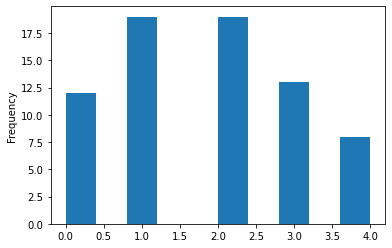

In [130]:
df_show_info['Topic'].plot(kind="hist")

# Evaluate the model

In [134]:
LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
 evaluate_every=-1, learning_decay=0.7,
 learning_method='online', learning_offset=10.0,
 max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
 n_components=10, n_jobs=-1, perp_tol=0.1,
 random_state=100, topic_word_prior=None,
 total_samples=1000000.0, verbose=0)

LatentDirichletAllocation(learning_method='online', n_jobs=-1, random_state=100)

In [138]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(vocabulary))
# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(vocabulary))
# See model parameters
print(lda_model.get_params())

Log Likelihood:  -236285.10274915758
Perplexity:  2625.484903962818
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'online', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 5, 'n_jobs': -1, 'perp_tol': 0.1, 'random_state': 100, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}
